# Import Packages

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import struct

# Custom Dataset Class

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        """
        Custom Dataset for MNIST using uncompressed .ubyte files.

        Args:
            images_path (str): Path to the images .ubyte file.
            labels_path (str): Path to the labels .ubyte file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = self._load_images(images_path)
        self.labels = self._load_labels(labels_path)
        self.transform = transform

    def _load_images(self, filepath):
        with open(filepath, 'rb') as f:
            # Read magic number, number of images, rows, and columns
            magic, num, rows, cols = struct.unpack(">IIII", f.read(16))

            # Verify the expected size (60,000 images x 784 pixels)
            expected_size = num * rows * cols
            data = np.frombuffer(f.read(), dtype=np.uint8)

            # Ensure data is of expected size (60000 * 784 for training images)
            if data.size != expected_size:
                raise ValueError(f"Expected {expected_size} bytes, but got {data.size}.")

            # Reshape the data into (num_images, 1, 28, 28)
            data = data.reshape(num, rows, cols)

        return torch.tensor(data, dtype=torch.float32) / 255.0  # Normalize to [0, 1]

    def _load_labels(self, filepath):
        with open(filepath, 'rb') as f:
            # Read magic number, number of labels
            magic, num = struct.unpack(">II", f.read(8))
            # Read label data
            data = np.frombuffer(f.read(), dtype=np.uint8)

        return torch.tensor(data, dtype=torch.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


# Data Preprocessing

In [3]:
# Transform for data normalization
transform = transforms.Compose([transforms.Lambda(lambda x: x.unsqueeze(0)), transforms.Normalize((0.5,), (0.5,))])

# Paths to MNIST .gz files
train_images_path = "train-images-idx3-ubyte"
train_labels_path = "train-labels-idx1-ubyte"
test_images_path = "t10k-images-idx3-ubyte"
test_labels_path = "t10k-labels-idx1-ubyte"

# Create Dataset instances
training_dataset = MNISTDataset(train_images_path, train_labels_path, transform=transform)
test_dataset = MNISTDataset(test_images_path, test_labels_path, transform=transform)
print("training dataset size: ", len(training_dataset))
print("test dataset size: ", len(test_dataset))

# Splitting Dataset into Training and Validation Sets
val_size = len(training_dataset) // 6  # 1/6 for validation
train_size = len(training_dataset) - val_size

train_dataset, val_dataset = random_split(training_dataset, [train_size, val_size])

print("Training dataset size after splitting:", len(train_dataset))
print("Validation dataset size after splitting:", len(val_dataset))
print("Testing dataset size remains unchanged:", len(test_dataset))

training dataset size:  60000
test dataset size:  10000
Training dataset size after splitting: 50000
Validation dataset size after splitting: 10000
Testing dataset size remains unchanged: 10000


# General class for our Neural Network Architectures

In [4]:
# Define the Feedforward Neural Network class
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, learning_rate, batch_size):
        super(FeedforwardNN, self).__init__()

        # Save learning rate and batch size for later use
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_size = input_size
        self.output_size = output_size

        # Create the layers of the neural network
        layers = []
        in_features = input_size
        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())  # Activation function for hidden layers
            in_features = hidden_units

        # Output layer
        layers.append(nn.Linear(in_features, output_size))

        # Combine layers in a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Train and Test Functions

In [5]:
# Define train_model and test_model functions
def train_model(model, train_dataset, val_dataset, criterion, optimizer, batch_size, input_size, epochs=10):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images = images.reshape(-1, input_size)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.reshape(-1, input_size)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [6]:
def test_model(model, test_dataset, input_size):
    test_loader = DataLoader(test_dataset, batch_size=model.batch_size, shuffle=False)
    n_correct = 0
    n_samples = len(test_loader.dataset)

    all_preds = []
    all_labels = []

    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = n_correct / n_samples
    print(f"Accuracy: {100 * acc:.2f} %")

    return acc

In [7]:
def plot_loss_curves(train_loss_curves, val_loss_curves, learning_rates, param_name):
    """
    Plots the training and validation loss curves for multiple learning rates.

    Args:
        train_loss_curves (dict): Training loss curves for each learning rate.
        val_loss_curves (dict): Validation loss curves for each learning rate.
        learning_rates (list): List of learning rates used.
    """
    plt.figure(figsize=(12, 6))
    for lr in learning_rates:
        plt.plot(range(1, len(train_loss_curves[lr]) + 1), train_loss_curves[lr], label=f'Train Loss ({param_name}={lr})')
        plt.plot(range(1, len(val_loss_curves[lr]) + 1), val_loss_curves[lr], '--', label=f'Val Loss ({param_name}={lr})')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves for Different Parameters')
    plt.legend()
    plt.show()

# Model Training and Validation

Epoch [1/10], Train Loss: 0.8559, Val Loss: 0.4610
Epoch [2/10], Train Loss: 0.3902, Val Loss: 0.3577
Epoch [3/10], Train Loss: 0.3384, Val Loss: 0.3229
Epoch [4/10], Train Loss: 0.3121, Val Loss: 0.3308
Epoch [5/10], Train Loss: 0.2932, Val Loss: 0.2879
Epoch [6/10], Train Loss: 0.2771, Val Loss: 0.2736
Epoch [7/10], Train Loss: 0.2629, Val Loss: 0.2633
Epoch [8/10], Train Loss: 0.2493, Val Loss: 0.2488
Epoch [9/10], Train Loss: 0.2373, Val Loss: 0.2417
Epoch [10/10], Train Loss: 0.2266, Val Loss: 0.2367


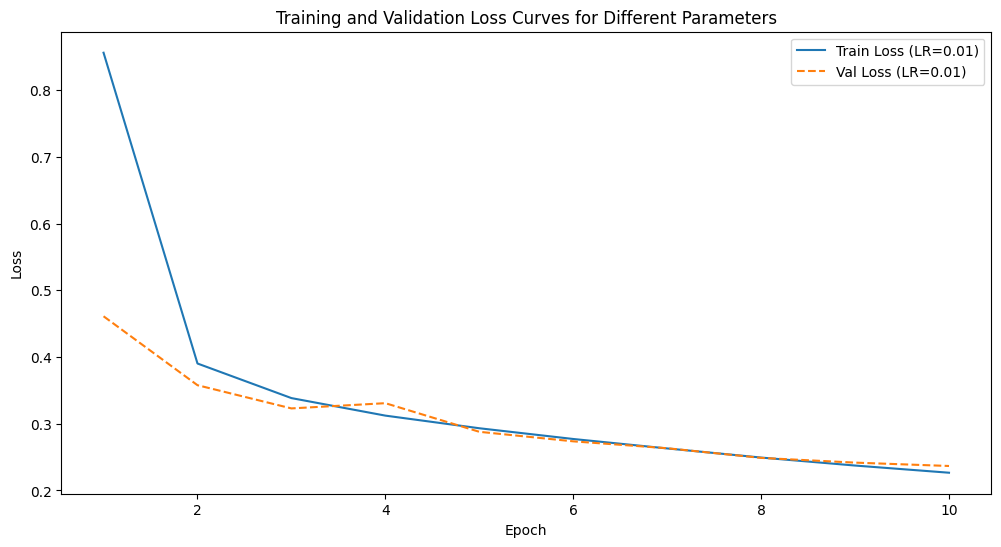

Accuracy: 93.60 %


0.936

In [8]:
# fixed parameters
input_size = 28*28      # size of image
output_size = 10        # number of digits

# hyperparameters
hidden_layers = 1
hidden_units = 60
learning_rate = 0.01
batch_size = 64

model = FeedforwardNN(input_size=input_size, output_size=output_size, hidden_layers=hidden_layers, hidden_units=hidden_units, learning_rate=learning_rate, batch_size=batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses, val_losses = train_model(model, train_dataset, val_dataset, criterion, optimizer, model.batch_size, model.input_size, epochs=10)
plot_loss_curves({learning_rate: train_losses}, {learning_rate: val_losses}, [learning_rate], 'LR')
test_model(model, test_dataset, model.input_size)

In [9]:
def run_experiments(param_values, param_name, fixed_params):
    """
    Runs experiments for varying one hyperparameter while keeping others fixed.

    Args:
        param_values (list): List of values to try for the hyperparameter.
        param_name (str): Name of the hyperparameter being varied.
        fixed_params (dict): Dictionary of fixed hyperparameters.

    Returns:
        dict: Training loss curves.
        dict: Validation loss curves.
        tuple: Best model, best validation loss, best parameter value.
    """
    best_model = None
    best_val_loss = float('inf')
    best_param_value = None

    train_loss_curves = {}
    val_loss_curves = {}

    for value in param_values:
        print(f"\nTraining model with {param_name} = {value}...\n")

        # Update the parameter being varied
        params = fixed_params.copy()
        params[param_name] = value

        # Initialize model
        model = FeedforwardNN(
            input_size=params['input_size'],
            output_size=params['output_size'],
            hidden_layers=params['hidden_layers'],
            hidden_units=params['hidden_units'],
            learning_rate=params['learning_rate'],
            batch_size=params['batch_size']
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])

        # Train the model
        train_losses, val_losses = train_model(
            model, train_dataset, val_dataset, criterion, optimizer,
            params['batch_size'], params['input_size'], epochs=20
        )

        # Save loss curves
        train_loss_curves[value] = train_losses
        val_loss_curves[value] = val_losses

        # Identify the best model
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model = model
            best_param_value = value

    return train_loss_curves, val_loss_curves, best_model, best_val_loss, best_param_value


# Testing Different Learning Rates

In [10]:
fixed_params = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': 1,
    'hidden_units': 60,
    'learning_rate': 0.01,
    'batch_size': 64
}


Training model with learning_rate = 0.7...

Epoch [1/20], Train Loss: 2.3154, Val Loss: 2.3037
Epoch [2/20], Train Loss: 2.3039, Val Loss: 2.3045
Epoch [3/20], Train Loss: 2.3038, Val Loss: 2.3073
Epoch [4/20], Train Loss: 2.3039, Val Loss: 2.3031
Epoch [5/20], Train Loss: 2.3035, Val Loss: 2.3048
Epoch [6/20], Train Loss: 2.3040, Val Loss: 2.3034
Epoch [7/20], Train Loss: 2.3039, Val Loss: 2.3081
Epoch [8/20], Train Loss: 2.3038, Val Loss: 2.3047
Epoch [9/20], Train Loss: 2.3037, Val Loss: 2.3058
Epoch [10/20], Train Loss: 2.3038, Val Loss: 2.3044
Epoch [11/20], Train Loss: 2.3039, Val Loss: 2.3032
Epoch [12/20], Train Loss: 2.3041, Val Loss: 2.3034
Epoch [13/20], Train Loss: 2.3037, Val Loss: 2.3048
Epoch [14/20], Train Loss: 2.3037, Val Loss: 2.3042
Epoch [15/20], Train Loss: 2.3039, Val Loss: 2.3041
Epoch [16/20], Train Loss: 2.3036, Val Loss: 2.3032
Epoch [17/20], Train Loss: 2.3040, Val Loss: 2.3024
Epoch [18/20], Train Loss: 2.3040, Val Loss: 2.3030
Epoch [19/20], Train Loss: 2

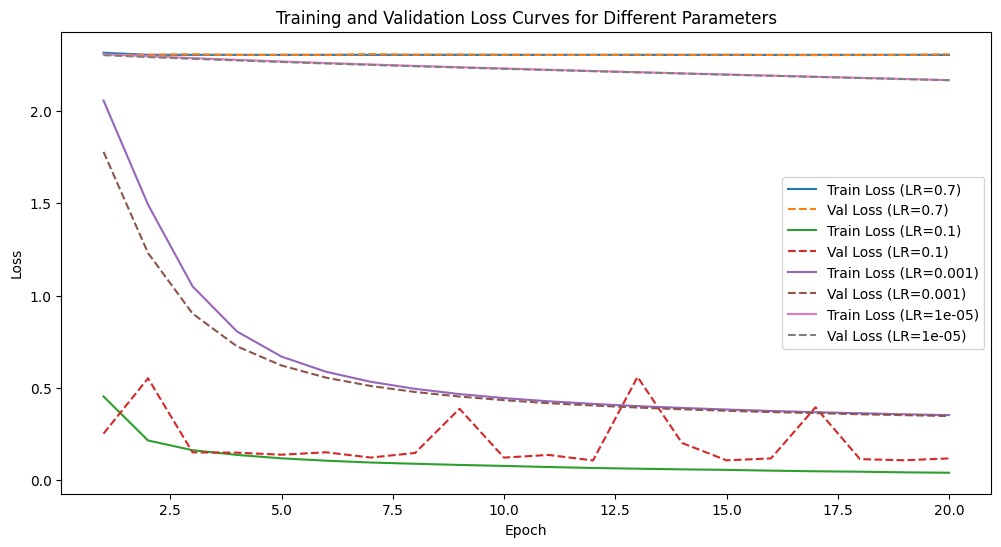


Best learning rate: 0.1 (Validation Loss: 0.1186)



In [11]:
# Experiment 1: Vary learning rate
learning_rates = [0.7, 0.1, 0.001, 0.00001]
train_loss_curves, val_loss_curves, best_model, best_val_loss, best_learning_rate = run_experiments(
    learning_rates, 'learning_rate', fixed_params
)
plot_loss_curves(train_loss_curves, val_loss_curves, learning_rates, 'LR')
print(f"\nBest learning rate: {best_learning_rate} (Validation Loss: {best_val_loss:.4f})\n")



Training model with batch_size = 1...

Epoch [1/20], Train Loss: 0.4352, Val Loss: 0.3050
Epoch [2/20], Train Loss: 0.2995, Val Loss: 0.2699
Epoch [3/20], Train Loss: 0.2596, Val Loss: 0.2676
Epoch [4/20], Train Loss: 0.2354, Val Loss: 0.2939
Epoch [5/20], Train Loss: 0.2205, Val Loss: 0.2429
Epoch [6/20], Train Loss: 0.2136, Val Loss: 0.2841
Epoch [7/20], Train Loss: 0.2055, Val Loss: 0.1995
Epoch [8/20], Train Loss: 0.1974, Val Loss: 0.2010
Epoch [9/20], Train Loss: 0.1947, Val Loss: 0.2842
Epoch [10/20], Train Loss: 0.1800, Val Loss: 0.2438
Epoch [11/20], Train Loss: 0.1823, Val Loss: 0.2281
Epoch [12/20], Train Loss: 0.1763, Val Loss: 0.2470
Epoch [13/20], Train Loss: 0.1747, Val Loss: 0.2834
Epoch [14/20], Train Loss: 0.1741, Val Loss: 0.2711
Epoch [15/20], Train Loss: 0.1672, Val Loss: 0.2515
Epoch [16/20], Train Loss: 0.1589, Val Loss: 0.2875
Epoch [17/20], Train Loss: 0.1555, Val Loss: 0.2223
Epoch [18/20], Train Loss: 0.1592, Val Loss: 0.2624
Epoch [19/20], Train Loss: 0.1576

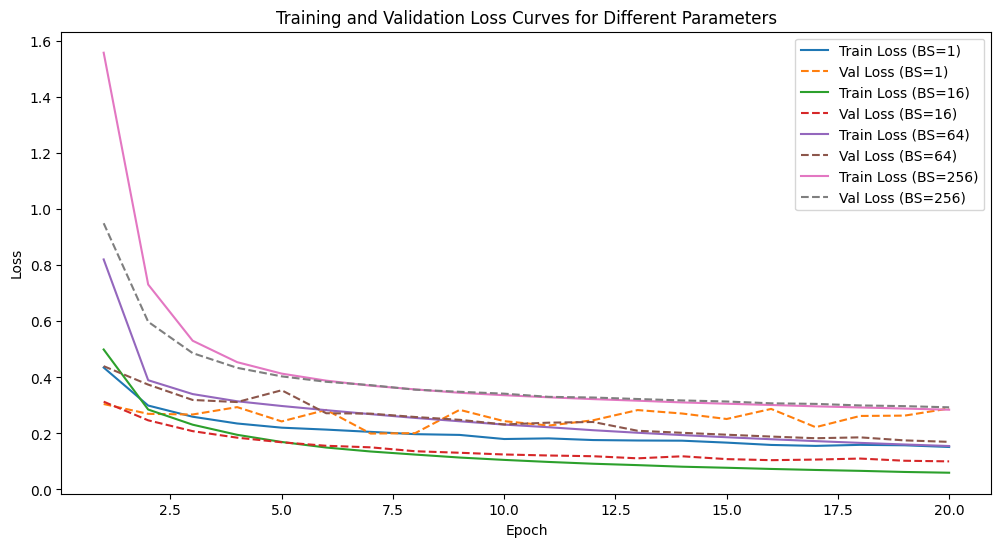


Best batch size: 16 (Validation Loss: 0.1002)



In [12]:
# Experiment 2: Vary batch size
batch_sizes = [1, 16, 64, 256]
train_loss_curves, val_loss_curves, best_model, best_val_loss, best_batch_size = run_experiments(
    batch_sizes, 'batch_size', fixed_params
)
plot_loss_curves(train_loss_curves, val_loss_curves, batch_sizes, 'BS')
print(f"\nBest batch size: {best_batch_size} (Validation Loss: {best_val_loss:.4f})\n")



Training model with hidden_layers = 1...

Epoch [1/20], Train Loss: 0.4888, Val Loss: 0.3105
Epoch [2/20], Train Loss: 0.2809, Val Loss: 0.2535
Epoch [3/20], Train Loss: 0.2290, Val Loss: 0.2073
Epoch [4/20], Train Loss: 0.1956, Val Loss: 0.1985
Epoch [5/20], Train Loss: 0.1719, Val Loss: 0.1646
Epoch [6/20], Train Loss: 0.1544, Val Loss: 0.1575
Epoch [7/20], Train Loss: 0.1392, Val Loss: 0.1436
Epoch [8/20], Train Loss: 0.1277, Val Loss: 0.1391
Epoch [9/20], Train Loss: 0.1188, Val Loss: 0.1258
Epoch [10/20], Train Loss: 0.1093, Val Loss: 0.1281
Epoch [11/20], Train Loss: 0.1020, Val Loss: 0.1184
Epoch [12/20], Train Loss: 0.0947, Val Loss: 0.1284
Epoch [13/20], Train Loss: 0.0889, Val Loss: 0.1105
Epoch [14/20], Train Loss: 0.0838, Val Loss: 0.1110
Epoch [15/20], Train Loss: 0.0788, Val Loss: 0.1060
Epoch [16/20], Train Loss: 0.0746, Val Loss: 0.1069
Epoch [17/20], Train Loss: 0.0707, Val Loss: 0.1085
Epoch [18/20], Train Loss: 0.0663, Val Loss: 0.1106
Epoch [19/20], Train Loss: 0.0

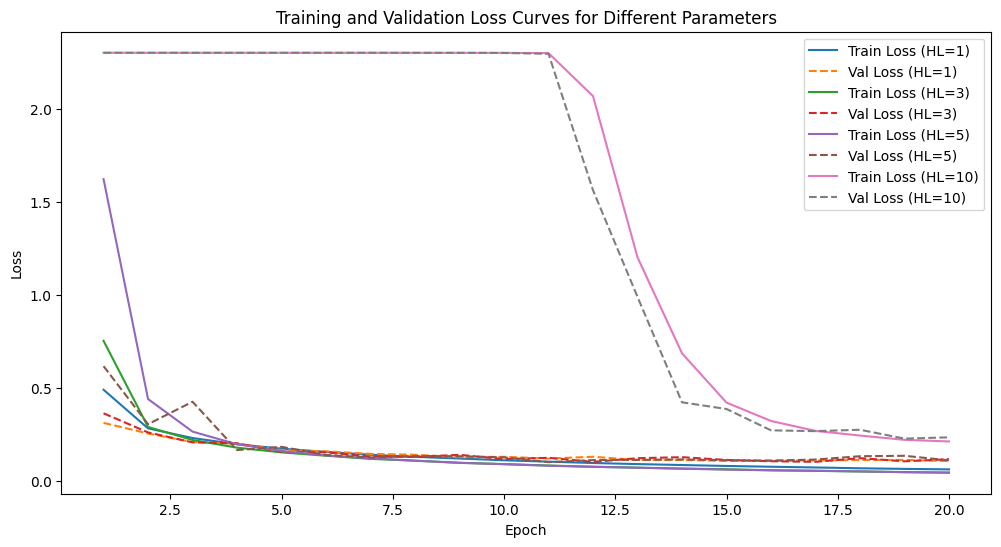


Best number of hidden layers: 1 (Validation Loss: 0.1050)



In [13]:
# Experiment 3: Vary number of hidden layers
hidden_layers_list = [1, 3, 5, 10]
fixed_params['batch_size'] = best_batch_size
train_loss_curves, val_loss_curves, best_model, best_val_loss, best_hidden_layers = run_experiments(
    hidden_layers_list, 'hidden_layers', fixed_params
)
plot_loss_curves(train_loss_curves, val_loss_curves, hidden_layers_list, 'HL')
print(f"\nBest number of hidden layers: {best_hidden_layers} (Validation Loss: {best_val_loss:.4f})\n")




Training model with hidden_units = 5...

Epoch [1/20], Train Loss: 0.7662, Val Loss: 0.5012
Epoch [2/20], Train Loss: 0.4850, Val Loss: 0.4511
Epoch [3/20], Train Loss: 0.4492, Val Loss: 0.4437
Epoch [4/20], Train Loss: 0.4329, Val Loss: 0.4480
Epoch [5/20], Train Loss: 0.4225, Val Loss: 0.4114
Epoch [6/20], Train Loss: 0.4157, Val Loss: 0.4143
Epoch [7/20], Train Loss: 0.4085, Val Loss: 0.4347
Epoch [8/20], Train Loss: 0.4050, Val Loss: 0.4286
Epoch [9/20], Train Loss: 0.4008, Val Loss: 0.4056
Epoch [10/20], Train Loss: 0.3959, Val Loss: 0.4017
Epoch [11/20], Train Loss: 0.3923, Val Loss: 0.3978
Epoch [12/20], Train Loss: 0.3896, Val Loss: 0.4106
Epoch [13/20], Train Loss: 0.3879, Val Loss: 0.4029
Epoch [14/20], Train Loss: 0.3847, Val Loss: 0.4274
Epoch [15/20], Train Loss: 0.3825, Val Loss: 0.4269
Epoch [16/20], Train Loss: 0.3807, Val Loss: 0.3909
Epoch [17/20], Train Loss: 0.3793, Val Loss: 0.3891
Epoch [18/20], Train Loss: 0.3770, Val Loss: 0.3859
Epoch [19/20], Train Loss: 0.37

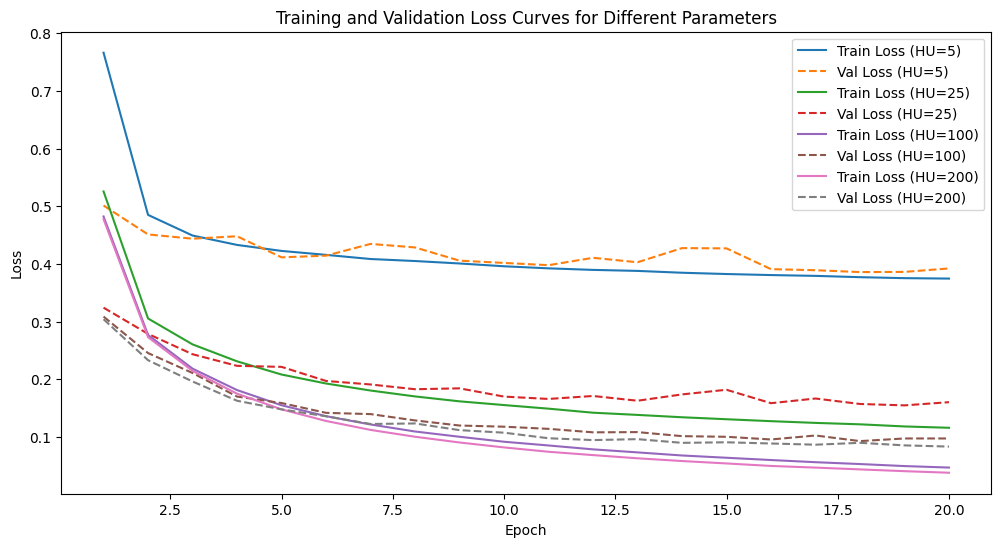


Best number of neurons: 200 (Validation Loss: 0.0833)



In [14]:
# Experiment 4: Vary number of neurons
num_neurons_list = [5, 25, 100, 200]
fixed_params['hidden_layers'] = best_hidden_layers
train_loss_curves, val_loss_curves, best_model, best_val_loss, best_num_neurons = run_experiments(
    num_neurons_list, 'hidden_units', fixed_params
)
plot_loss_curves(train_loss_curves, val_loss_curves, num_neurons_list, 'HU')
print(f"\nBest number of neurons: {best_num_neurons} (Validation Loss: {best_val_loss:.4f})\n")
